# 보팅분류기

In [3]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [10]:
# 데이터 로딩
cancer = load_breast_cancer()
data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [8]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(cancer.data,
                                                    cancer.target, 
                                                    test_size=0.2, 
                                                    random_state=0 )

In [9]:
# 보팅분류기 생성
lr_clf = LogisticRegression(solver='liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=7)
vo_clf = VotingClassifier(estimators=[('LR',lr_clf), ('KNN', knn_clf)],
                          voting='soft')

In [11]:
# 분류기 학습 - 예측 - 평가
vo_clf.fit(X_train, y_train)
vo_pred = vo_clf.predict(X_test)
accuracy_score(y_test, vo_pred)

0.956140350877193

In [12]:
confusion_matrix(y_test, vo_pred)

array([[44,  3],
       [ 2, 65]])

In [14]:
print(classification_report(y_test, vo_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95        47
           1       0.96      0.97      0.96        67

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones

In [15]:
import pandas as pd

def get_new_feature_name_df(old_feature_name_df):
    # 중복된 feature 이름 처리: 이름 뒤에 _0, _1, ... 등의 suffix 추가
    feature_dup_df = old_feature_name_df.groupby('column_name').cumcount()
    new_feature_name_df = old_feature_name_df.copy()
    new_feature_name_df['column_name'] = new_feature_name_df['column_name'] + "_" + feature_dup_df.astype(str)
    return new_feature_name_df

def get_human_dataset(base_path='./data/UCI-HAR_Dataset/'):
    # 피처 이름 로딩
    feature_path = base_path + 'features.txt'
    feature_name_df = pd.read_csv(feature_path, sep='\s+', header=None, names=['column_index', 'column_name'])

    # 중복 피처명 처리
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    feature_names = new_feature_name_df['column_name'].tolist()

    # 학습/테스트 데이터 로딩
    X_train = pd.read_csv(base_path + 'train/X_train.txt', sep='\s+', names=feature_names)
    X_test = pd.read_csv(base_path + 'test/X_test.txt', sep='\s+', names=feature_names)

    y_train = pd.read_csv(base_path + 'train/y_train.txt', sep='\s+', header=None, names=['action'])
    y_test = pd.read_csv(base_path + 'test/y_test.txt', sep='\s+', header=None, names=['action'])

    return X_train, X_test, y_train, y_test


In [16]:
X_train, X_test, y_train, y_test = get_human_dataset()

print(X_train.shape, X_test.shape)
print(y_train['action'].value_counts())


(7352, 561) (2947, 561)
action
6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: count, dtype: int64


# 랜덤포레스트로 모델 만들기

In [17]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=0, max_depth=8)
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
accuracy_score(y_test, rf_pred)


c:\Users\Admin\miniconda3\envs\hi_ml_env\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.9195792331184255

In [ ]:
# 랜덤포레스트 모델의 최적의 하이퍼파라미터 조합 찾기

In [18]:
# 피처 중요도 출력
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importances(model, feature_names, top_n=20):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]
    plt.figure(figsize=(10, top_n * 0.4))  # 피처 수에 따라 자동 높이 조절

    plt.barh(range(top_n), importances[indices][::-1], align='center')
    plt.yticks(range(top_n), np.array(feature_names)[indices][::-1])
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title(f'Top {top_n} Feature Importances')
    plt.tight_layout()
    plt.show()



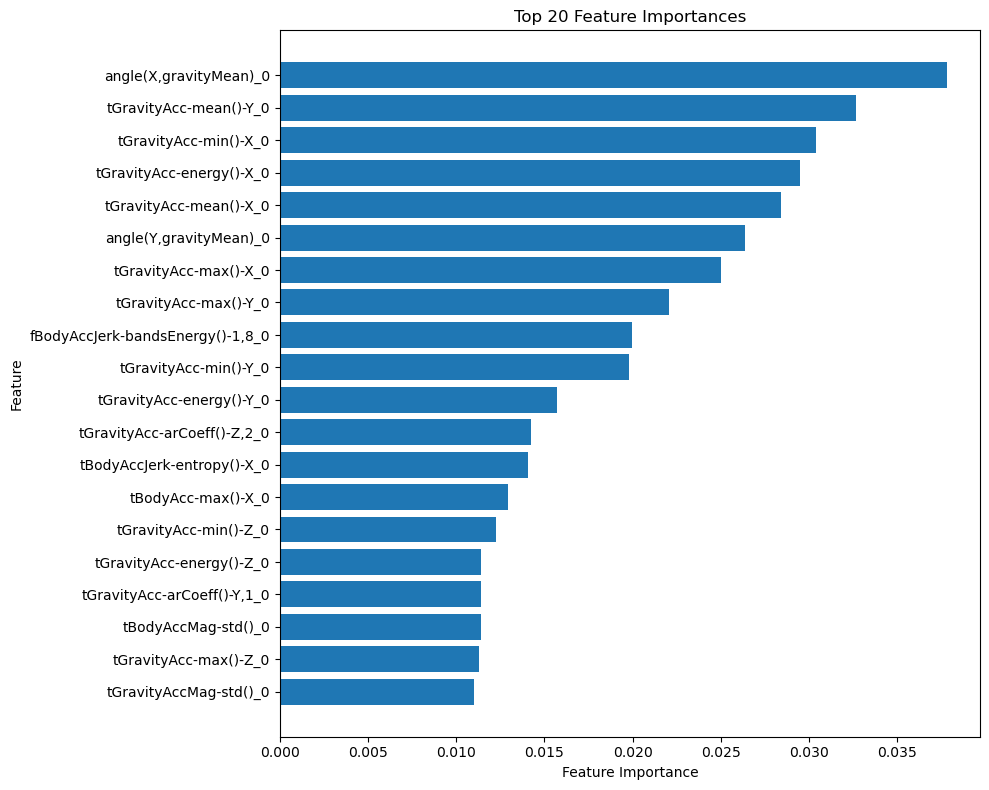

In [19]:
plot_feature_importances(rf_clf, feature_names=X_train.columns)